In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno as msno
import seaborn as sns
from fancyimpute import SoftImpute
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.cat_boost import  CatBoostEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
import os
print(os.listdir("data"))
path = 'data/orange_small_train.data/'

['orange_small_test.data', 'orange_small_train_appetency.labels', 'orange_small_train_churn.labels', '.ipynb_checkpoints', 'orange_small_train_upselling.labels', 'orange_small_train.data']


In [3]:
df = pd.read_table(path + 'orange_small_train.data')

In [4]:
print('There are %s observations and %s variables' %(df.shape))
df.head()

There are 50000 observations and 230 variables


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [5]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [6]:
df.isnull().sum()

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

We look at the missing values in the data using missingno package. Clearly from the below plot, it is evident that we need to remove columns with all missing data and proceed with an imputation to make the data worthwhile

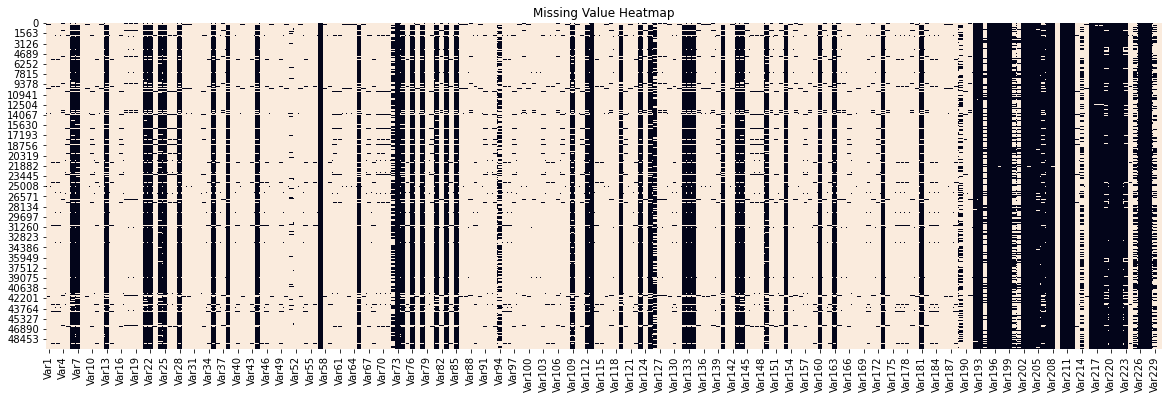

In [7]:
plt.figure(figsize=(20,6))
plt.title('Missing Value Heatmap')
plt.xlabel('Features')
plt.ylabel('Indices of Dataframe')
sns.heatmap(df.isnull(), cbar=False)
plt.show()

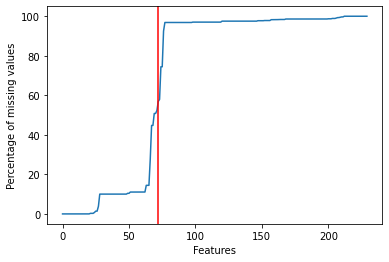

In [8]:
# to do any kind of worthwhile imputation on our data, we need to define a threshold where it would make sense to impute

plt.plot(sorted([df[i].isna().sum()*100/len(df[i]) for i in df]))
plt.axvline(x=72, color='r', linestyle='-')
plt.xlabel('Features')
plt.ylabel('Percentage of missing values')
plt.show()

 from the plot above, viable feature columns are approx. 70. Given that out of 230 columns, only about 70 columns
 have less than 30-40 percent data missing, it's possible that the next step is probably not the best choice.

In [9]:
df_clean = df.copy()

In [10]:
# drop columns with all values NaN
df_clean = df_clean.dropna(axis=1, how='all')
df_clean.shape

(50000, 212)

In [11]:
# drop columns with more than 70 percent NaN values
df_clean = df_clean.dropna(thresh=0.7*len(df), axis=1)
df_clean.shape

(50000, 67)

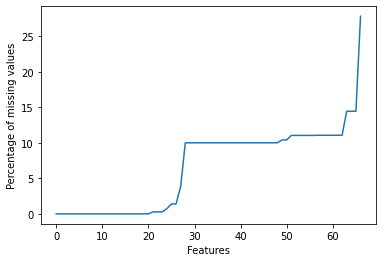

In [12]:
plt.plot(sorted([df_clean[i].isna().sum()*100/len(df_clean[i]) for i in df_clean]))
plt.xlabel('Features')
plt.ylabel('Percentage of missing values')
plt.show()

<AxesSubplot:>

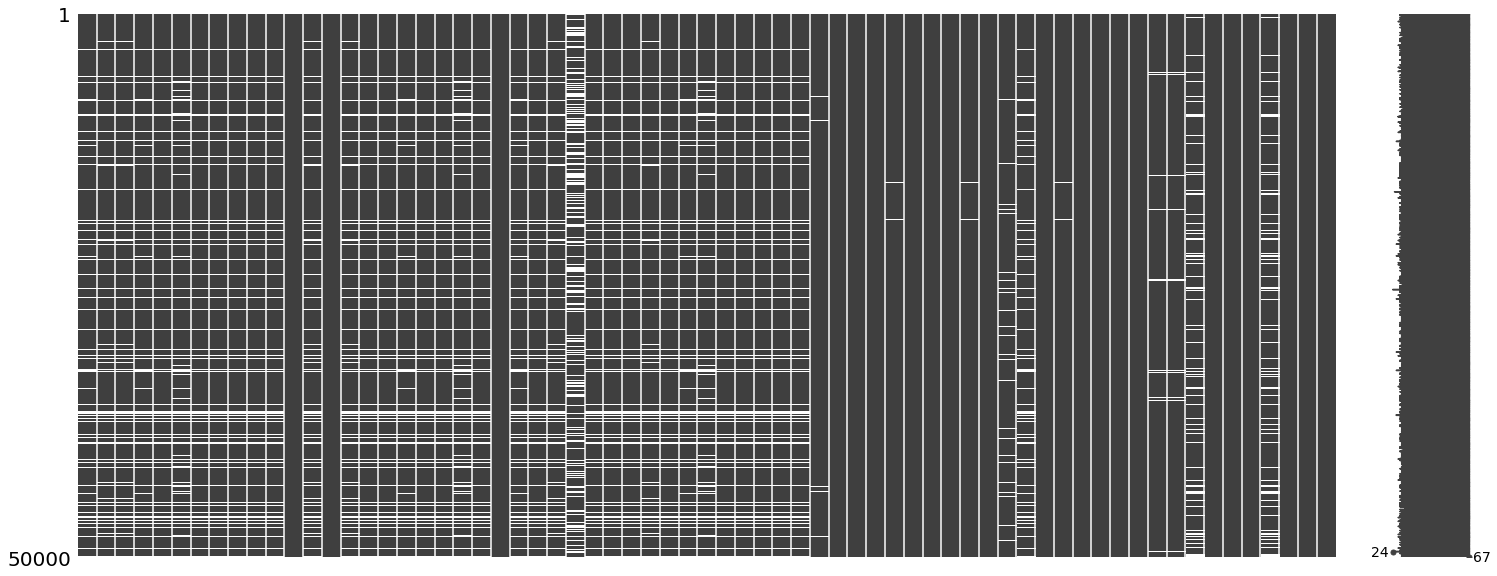

In [13]:
msno.matrix(df_clean)

remove features with zero variance as tree based models cannot split on such?

 decided not to remove more data

In [14]:
# check in entire rows have missing values 
df_clean.isna().all(axis=1).sum()

0

In [15]:
# determine categorical and numerical features
numerical_ix = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_clean.select_dtypes(include=['object', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 39
Categorical features : 28


In [16]:
# unique number of categories in categorical features
cat_df = df_clean.select_dtypes(include=['object', 'bool'])

u_vals = {}
for col in categorical_ix:
    u_vals[col] = cat_df[col].value_counts().shape[0]
unique_df = pd.Series(u_vals).sort_values(ascending=True)
unique_df = pd.DataFrame(unique_df)

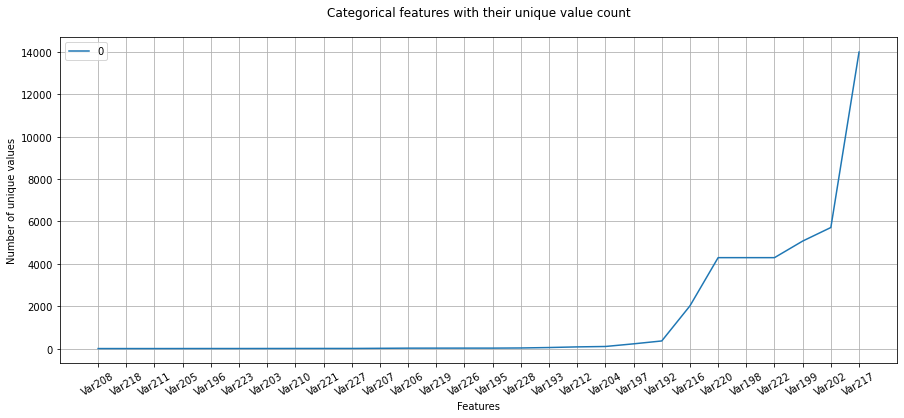

In [17]:
columns = list(unique_df.T)
fig, ax = plt.subplots(figsize=(15, 6))
unique_df[unique_df[0] > 0].plot(kind='line', ax=ax)
plt.title('Categorical features with their unique value count\n')
plt.xticks(np.arange(len(columns)),columns,rotation=30)
plt.xlabel('Features')
plt.ylabel('Number of unique values')
plt.grid()
plt.show()

 This shows we have high cardinality in some of the categorical features.

 drop features with too many categories based on number of values in each category
 Given that some of the features have over a 1000 unique categories, and hence a small sample count for each of those
 categories given 50000 rows, it is difficult to know if those categories would appear in the test data.
 The model might overfit for such features and it is also possible that such features dont contribute to the 
 effective predictiveness of the model. Hence we choose to drop them. 

In [18]:
# before we drop, lets ensure that the value count in the top category in these features is actually small

drop_cat = list(unique_df[unique_df[0] > 1000].T)
print(drop_cat)

for cat in drop_cat:
    print(cat, df_clean[cat].value_counts()[0])

['Var216', 'Var220', 'Var198', 'Var222', 'Var199', 'Var202', 'Var217']
Var216 4937
Var220 4441
Var198 4441
Var222 4441
Var199 955
Var202 198
Var217 283


In [19]:
df_clean['Var216'].value_counts()

mAjbk_S    4937
mAja5EA    4160
kZJtVhC    3390
XTbPUYD    3077
beK4AFX    1903
           ... 
y5FBXxb       1
OFq73P4       1
mAj7L05       1
kZJCWn0       1
TDcgzdV       1
Name: Var216, Length: 2016, dtype: int64

In [20]:
# drop features with less samples for large number of categories; keep Var216 as it has 2000 cats and decent sample size for top 4 cats

df_dropcat = df_clean.copy()
df_dropcat = df_dropcat.drop(drop_cat[1:],axis=1)
categorical_ix = df_dropcat.select_dtypes(include=['object', 'bool']).columns
len(categorical_ix)

22

In [21]:
# unique number of categories in categorical features
cat_df = df_dropcat.select_dtypes(include=['object', 'bool'])
u_vals = {}
for col in categorical_ix:
    u_vals[col] = cat_df[col].value_counts().shape[0]
unique_df = pd.Series(u_vals).sort_values(ascending=True)
unique_df = pd.DataFrame(unique_df)

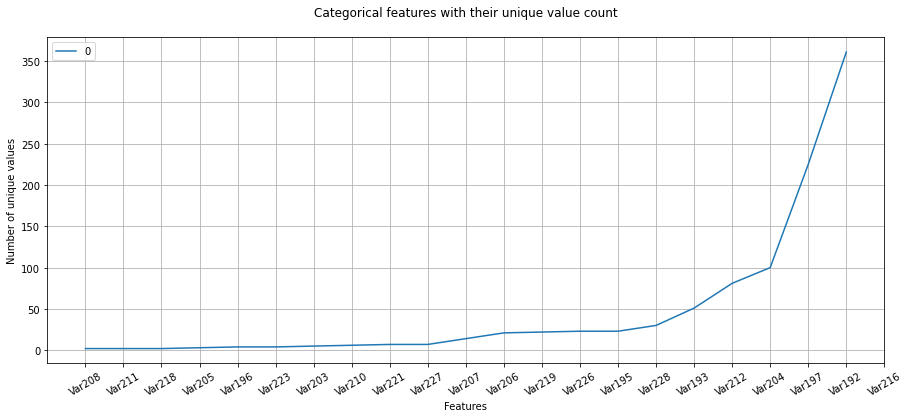

In [22]:
columns = list(unique_df.T)
fig, ax = plt.subplots(figsize=(15, 6))
unique_df[unique_df[0] > 0][:-1].plot(kind='line', ax=ax)
plt.title('Categorical features with their unique value count\n')
plt.xticks(np.arange(len(columns)),columns,rotation=30)
plt.xlabel('Features')
plt.ylabel('Number of unique values')
plt.grid()
plt.show()

# not shown Var216. Can be seen in the above plot.

The original categorical values where symbols, not indicating any category ordering. 
The category symbols have been replaced by random anonymized values (strings) with no semantic, 
in 1 to 1 bijection with the original values so as to keep the structure of the data.

this is why oridinal encoding is not feasible.

And given the number of features with over 100 unique categories, one hot encoding will be resource intensive.

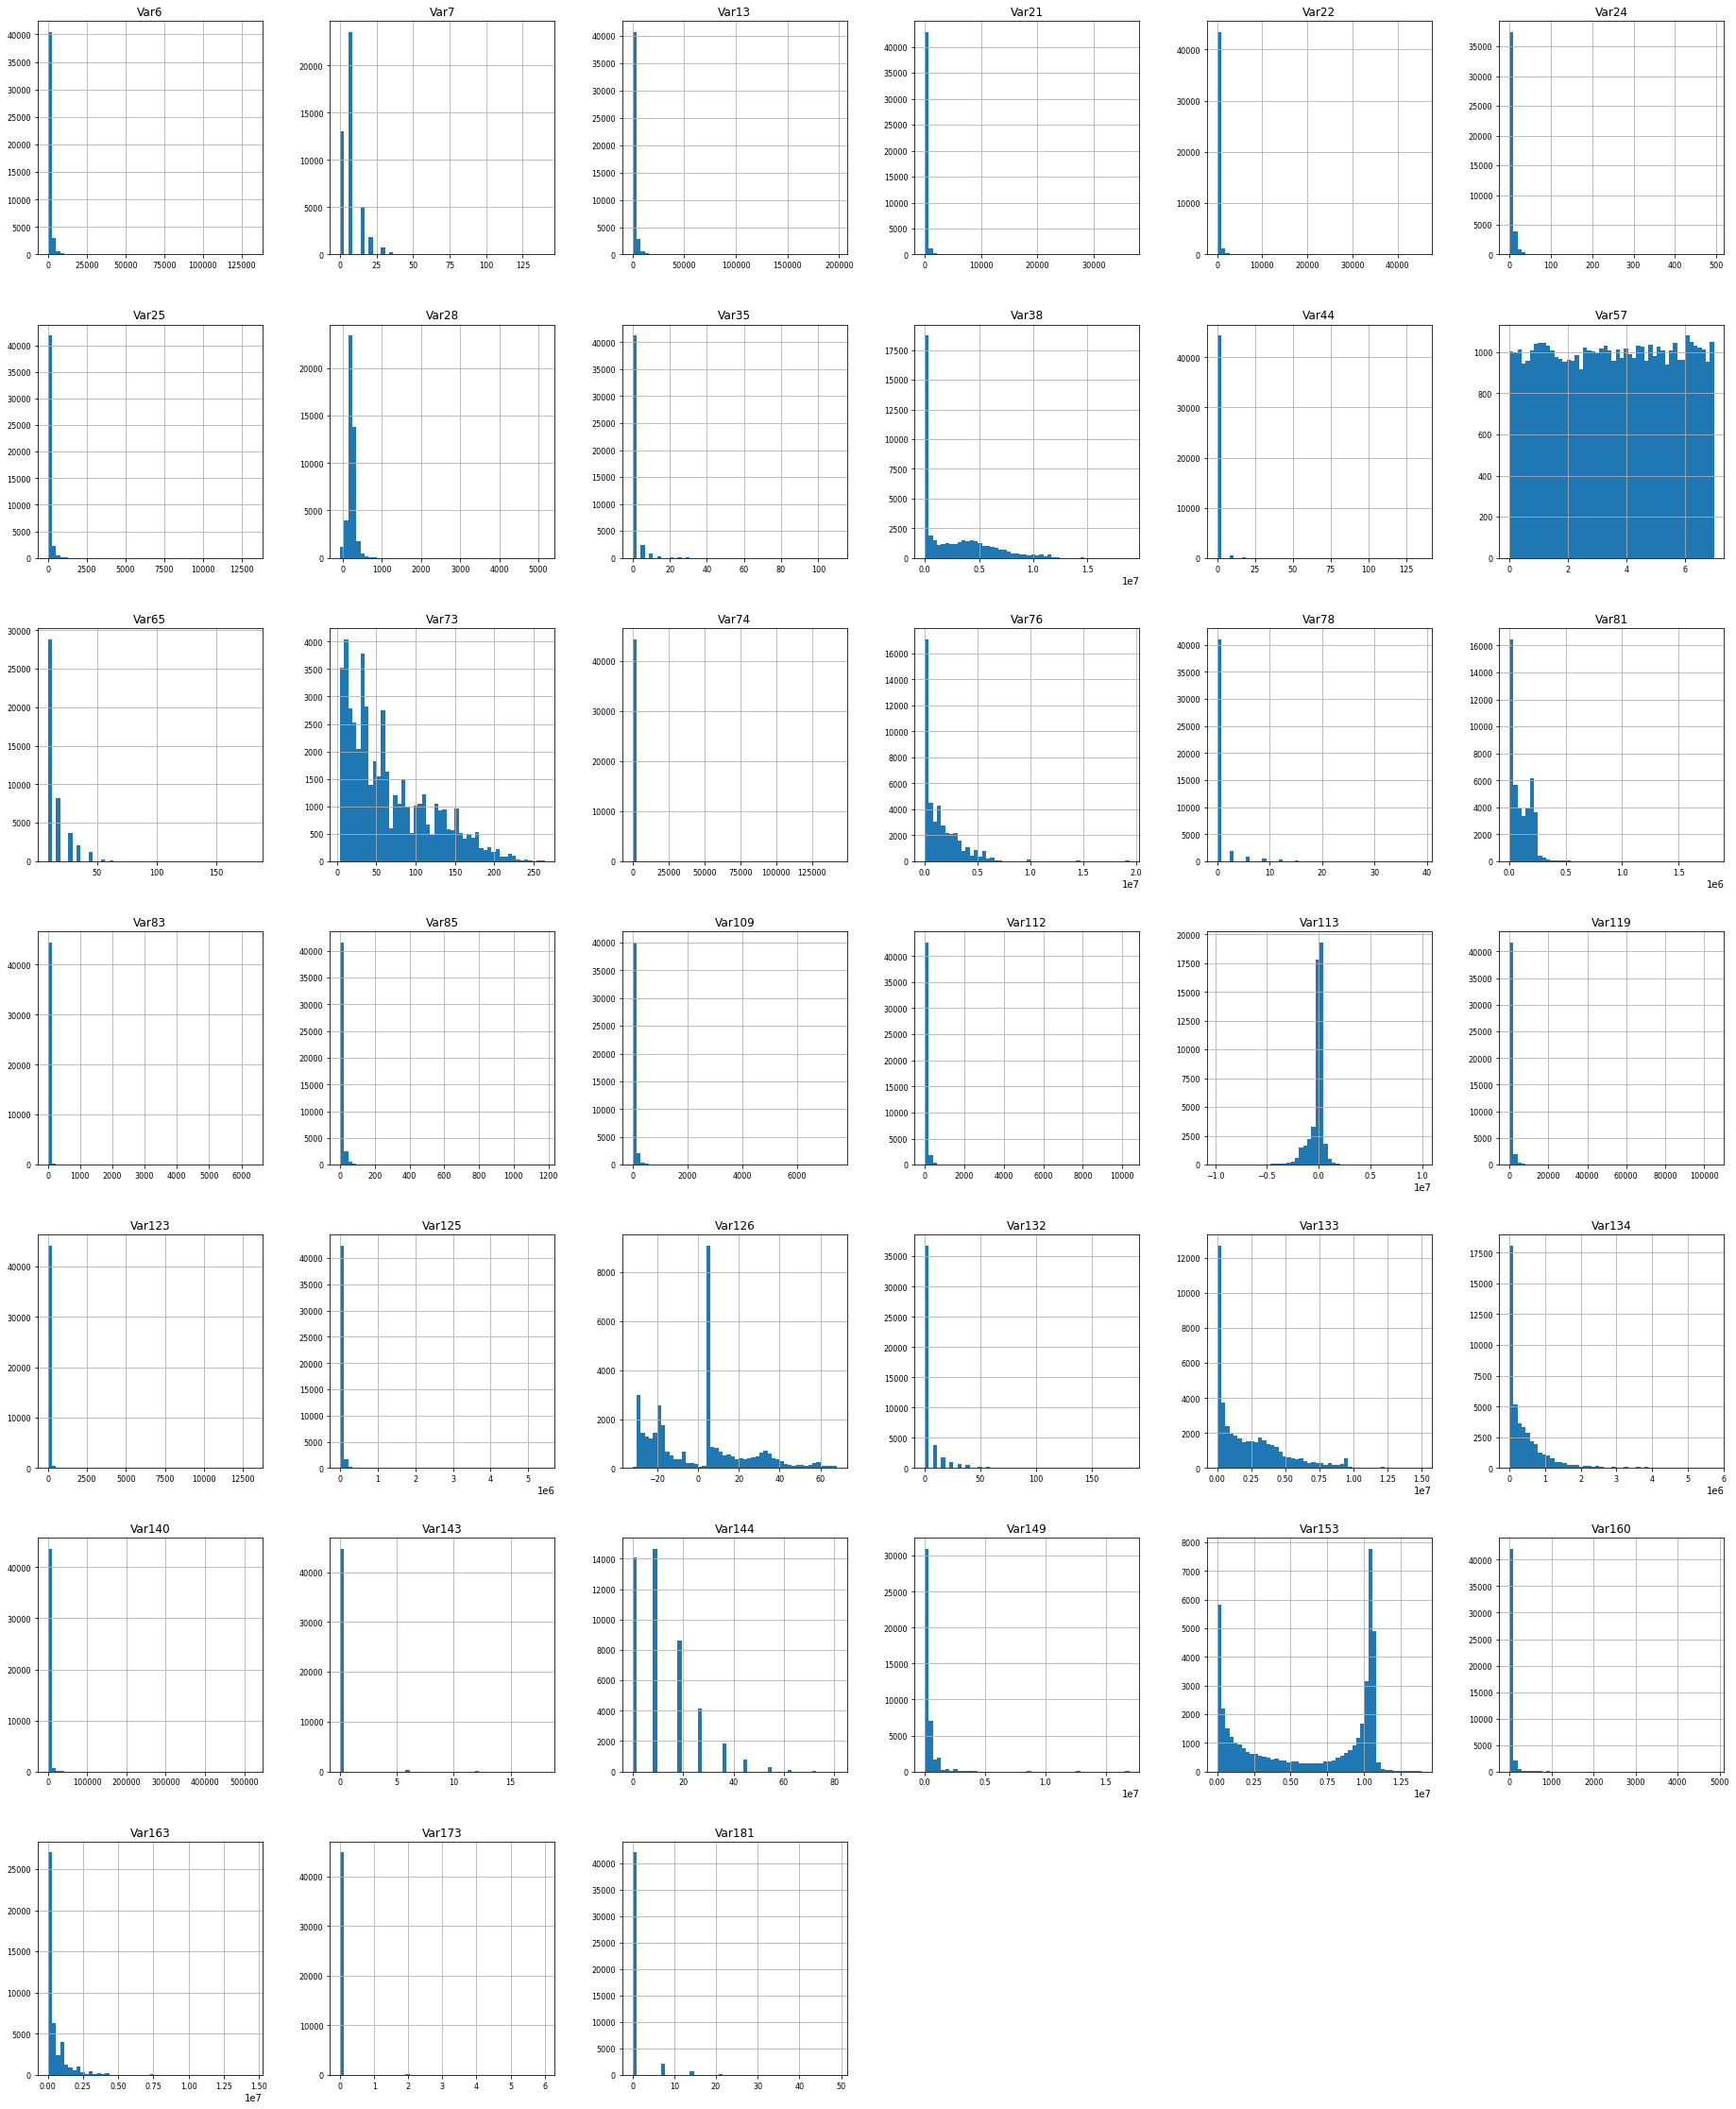

In [23]:
df_dropcat.hist(figsize=(32, 40), bins=50, xlabelsize=8, ylabelsize=8);

Standardization of the data is required from the above histograms

<AxesSubplot:>

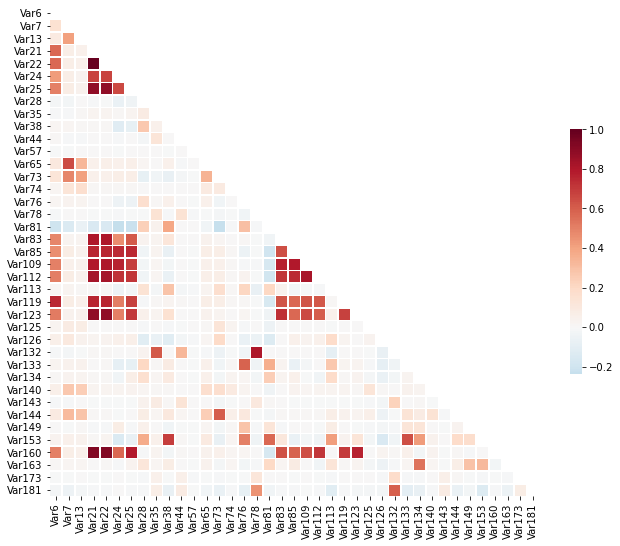

In [24]:
corr = df_dropcat.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0,annot=False, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Var22 and Var21 are highly correlated. So is Var160 with Var21 and Var22. 
need to do some feature engineering and selection to deal with highly linear features
this we will do with our training data

In [25]:
# dealing with highly correlated data

#we remove collinear data in order to make the model simple. Which tree and boosting models such as xgb are
# immune to collinearity, nonetheless, we think its best to remove them

# we remove features with a pearson's correlation value of more than 0.95 between each other

df_dropfeat = df_dropcat.copy()
cor_matrix = df_dropcat.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['Var22']


In [26]:
df_dropfeat = df_dropcat.drop(to_drop, axis=1)

In [27]:
numerical_ix = df_dropfeat.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_dropfeat.select_dtypes(include=['object', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 38
Categorical features : 22


<AxesSubplot:>

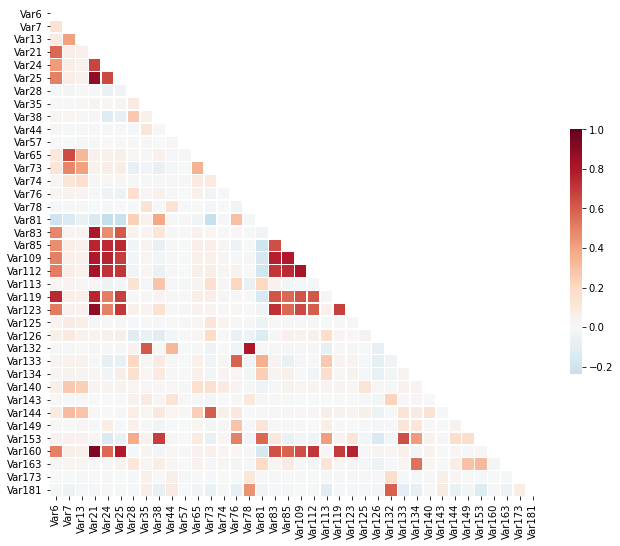

In [28]:
corr = df_dropfeat.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='RdBu_r',vmax=1, center=0,annot=False, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

 we keep the other features as tree based models and boosting algorithms are not affect by it. 
nevertheless, the regression model will probably overfit and inference will be difficult 
hence LassoRegularization is advised.

In [29]:
# feature enginnering
# we can check if there is any relationship with missing values between columns and add it to the dataframe

def nan_val_check(df):
    column = list(df.columns) 
    
    for col in column:
        binary_val = [] 
        binary_list = list(df[col].isna())
        for val in binary_list:
            if val == False:
                binary_val.append(0)
            else:
                binary_val.append(1)
        df["nan_" + col] = binary_val  
    return(df)

In [30]:
df_featengg = df_dropfeat.copy()
df_featengg = nan_val_check(df_featengg) # this will serve like a missing indicator 
df_featengg.shape

(50000, 120)

In [31]:
numerical_ix = df_featengg.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_featengg.select_dtypes(include=['object', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


In [32]:
df_featengg.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,nan_Var211,nan_Var212,nan_Var216,nan_Var218,nan_Var219,nan_Var221,nan_Var223,nan_Var226,nan_Var227,nan_Var228
0,1526.0,7.0,184.0,464.0,14.0,128.0,166.56,0.0,3570.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,525.0,0.0,0.0,168.0,2.0,24.0,353.52,0.0,4764966.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,5236.0,7.0,904.0,1212.0,26.0,816.0,220.08,0.0,5883894.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0.0,0.0,NaN,NaN,0.0,22.08,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1029.0,7.0,3216.0,64.0,4.0,64.0,200.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_impute = df_featengg.copy()

In [34]:
numerical_ix = df_featengg.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_featengg.select_dtypes(include=['object', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


In [35]:
# impute columns with missing value and add a missing value indicator to show that the value is imputed
# SoftImpute(): Matrix completion by iterative soft thresholding of SVD decompositions
# induce sparsity using singular value thresholding
# more: https://web.stanford.edu/~hastie/swData/softImpute/vignette.html

# Numerical variables
df_impute[numerical_ix] = SoftImpute().fit_transform(df_impute[numerical_ix])

[SoftImpute] Max Singular Value of X_init = 1894229937.638370
[SoftImpute] Iter 1: observed MAE=8706.378553 rank=8
[SoftImpute] Iter 2: observed MAE=8708.770543 rank=8
[SoftImpute] Iter 3: observed MAE=8709.605103 rank=8
[SoftImpute] Iter 4: observed MAE=8710.066915 rank=8
[SoftImpute] Iter 5: observed MAE=8710.341245 rank=8
[SoftImpute] Iter 6: observed MAE=8710.520217 rank=8
[SoftImpute] Iter 7: observed MAE=8710.649981 rank=8
[SoftImpute] Iter 8: observed MAE=8710.752586 rank=8
[SoftImpute] Iter 9: observed MAE=8710.838682 rank=8
[SoftImpute] Iter 10: observed MAE=8710.913785 rank=8
[SoftImpute] Iter 11: observed MAE=8710.981208 rank=8
[SoftImpute] Iter 12: observed MAE=8711.042427 rank=8
[SoftImpute] Iter 13: observed MAE=8711.098439 rank=8
[SoftImpute] Iter 14: observed MAE=8711.150108 rank=8
[SoftImpute] Iter 15: observed MAE=8711.198100 rank=8
[SoftImpute] Iter 16: observed MAE=8711.242865 rank=8
[SoftImpute] Iter 17: observed MAE=8711.284849 rank=8
[SoftImpute] Iter 18: observe

In [36]:
# Categorical variables as missing imputation
for col in categorical_ix:
    df_impute[col] = df_impute[col].astype('category')
    
for col in categorical_ix:
    df_impute[col] = df_impute[col].cat.add_categories('missing')
    df_impute[col] = df_impute[col].fillna('missing')
    
#  this ensures that we are not losing any samples and not making any assumptions on features distribution.

In [37]:
numerical_ix = df_impute.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_impute.select_dtypes(include=['object', 'bool', 'category']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


In [38]:
# convert missing categorical variables using SimpleImpute()

df_newimpute = df_featengg.copy()

impute = SimpleImputer(strategy='most_frequent')
df_newimpute[numerical_ix] = impute.fit_transform(df_newimpute[numerical_ix])
df_newimpute[categorical_ix] = impute.fit_transform(df_newimpute[categorical_ix])

In [39]:
df_newimpute[categorical_ix] = df_newimpute[categorical_ix].astype('category')
df_newimpute.dtypes.unique

<bound method Series.unique of Var6          float64
Var7          float64
Var13         float64
Var21         float64
Var24         float64
               ...   
nan_Var221    float64
nan_Var223    float64
nan_Var226    float64
nan_Var227    float64
nan_Var228    float64
Length: 120, dtype: object>

In [40]:
numerical_ix = df_newimpute.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df_newimpute.select_dtypes(include=['object', 'bool', 'category']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


<AxesSubplot:>

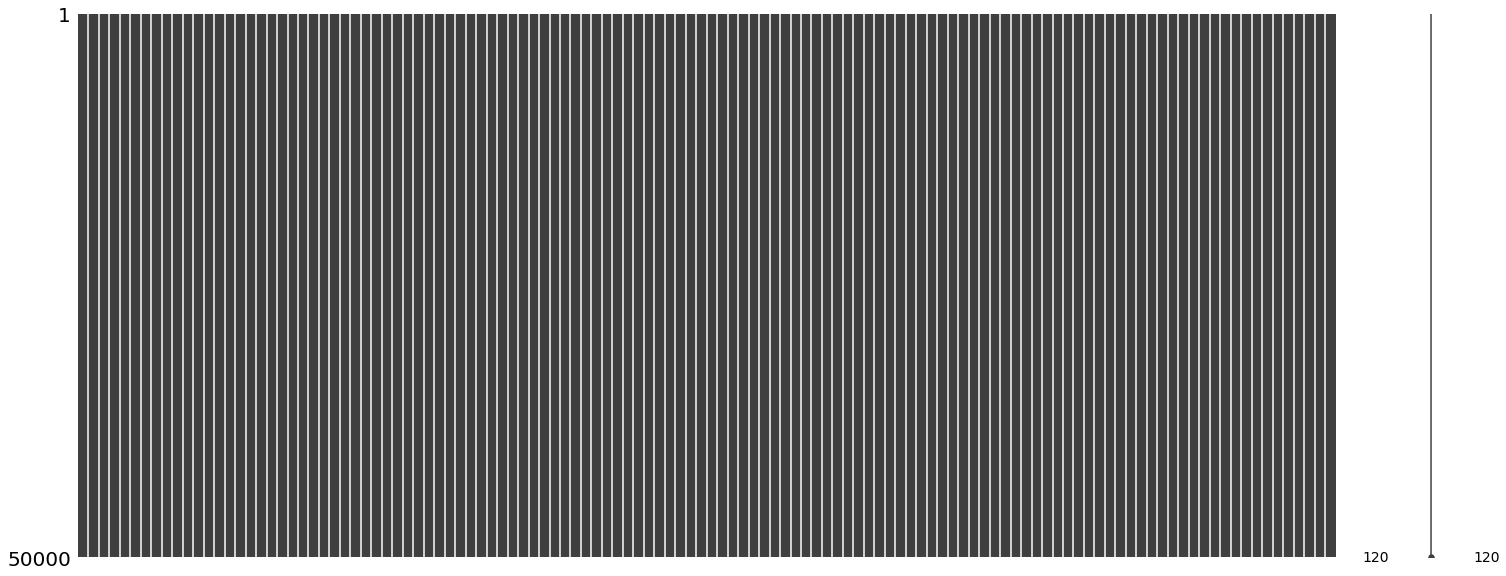

In [41]:
msno.matrix(df_impute)

In [42]:
# labels
label1 = pd.read_csv('data/orange_small_train_appetency.labels',header = None)
label2 = pd.read_csv('data/orange_small_train_churn.labels',header = None)
label3 = pd.read_csv('data/orange_small_train_upselling.labels',header = None)

In [43]:
labels = pd.concat([label1, label2, label3], axis=1)
labels.columns = ['Appetency', 'Churn','Upselling']
print(labels.head(10))

   Appetency  Churn  Upselling
0         -1     -1         -1
1         -1      1         -1
2         -1     -1         -1
3         -1     -1         -1
4         -1     -1         -1
5         -1     -1         -1
6         -1     -1         -1
7         -1     -1         -1
8         -1     -1         -1
9         -1     -1         -1


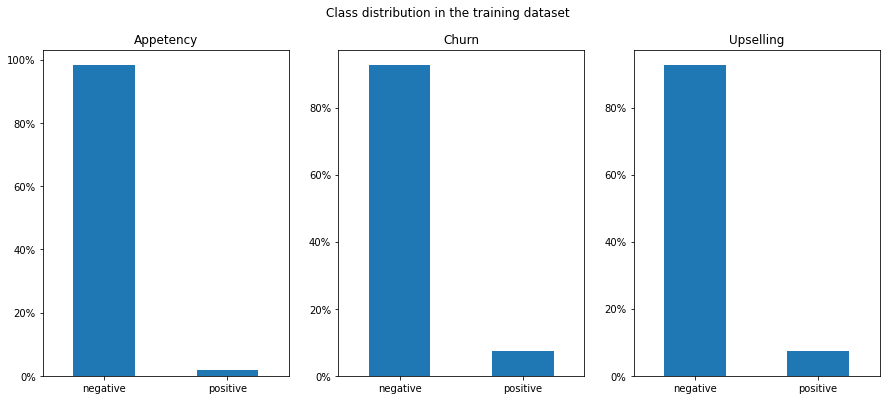

In [44]:
#Plot class label distribution for each target variable

fig = plt.figure(figsize = (15,6))
fig.suptitle("Class distribution in the training dataset")
classNames = ['negative','positive']
tick_marks = np.arange(len(classNames))

a1 = fig.add_subplot(1,3,1)
a1.set_title("Appetency")

a=labels['Appetency'].value_counts() #labelount by labelalue
da = a/sum(a)*100 #label distribution
a1 = da.plot(kind='bar') #plot bar chart for class labels
a1.yaxis.set_major_formatter(mtick.PercentFormatter())#format y-axis as percent
plt.xticks(tick_marks, classNames, rotation=0)


a2 = fig.add_subplot(1,3,2)
a2.set_title("Churn")
c=labels['Churn'].value_counts() 
dc = c/sum(c)*100 
a2 = dc.plot(kind='bar')
a2.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(tick_marks, classNames, rotation=0)

a3 = fig.add_subplot(1,3,3)
a3.set_title("Upselling")
u=labels['Upselling'].value_counts() 
du = u/sum(u)*100 
a3 = du.plot(kind='bar') 
a3.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(tick_marks, classNames, rotation=0)
    
plt.show()

In [45]:
df_impute1 = pd.concat([df_impute, labels], axis =1)

In [46]:
# we will only save the soft imputation file and work with it for our ensemble models
df_impute1.to_pickle('soft_impute.pickle')